# 9 - TensorFlow CNN with Bayesian Convolutional Layer

Now that we've trained a CNN including an estimator of aleatoric uncertainty, let's take a look at how to train that same network with support for _epistemic_ uncertainty -- uncertainty in the shape of the model itself. 

We've so far only used the `tfp.layers.DenseVariational` for epistemic uncertainty in neural networks, but TensorFlow Probability ships with a full complement of Bayesian layers that define distributions over their weights. Check out the full list in the documentation, [here](https://www.tensorflow.org/probability/api_docs/python/tfp/layers).

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_probability as tfp

print(tf.__version__)
tf.get_logger().setLevel('ERROR')

2.0.0


We'll use the same `plot_image` and `plot_value_array` functions that we've defined for all of the image classification problems.

In [2]:
def plot_image(i: int, predictions_array: np.ndarray, true_label: np.ndarray, img: np.ndarray):
    """
    Plot an image from the passed set, along with its true and predicted label.
    """
    
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    true_label = true_label.squeeze()
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label.squeeze():
        color = 'blue'
    else:
        color = 'red'


    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i: int, predictions_array: np.ndarray, true_label: np.ndarray):
    """
    Plot a bar chart of the model activations for each class pertaining to a given image.
    """
    
    predictions_array, true_label = predictions_array, true_label[i]
    
    true_label = true_label.squeeze()
    
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

## Load training data

Once again, we'll use CIFAR-10 as our training data set.

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

train_images = np.array(train_images[[i for (i, label) in enumerate(train_labels) if label in [0, 2]]])
train_labels = np.array([label for label in train_labels if label in [0, 2]]) // 2
test_images = np.array(test_images[[i for (i, label) in enumerate(test_labels) if label in [0, 2]]])
test_labels = np.array([label for label in test_labels if label in [0, 2]]) // 2

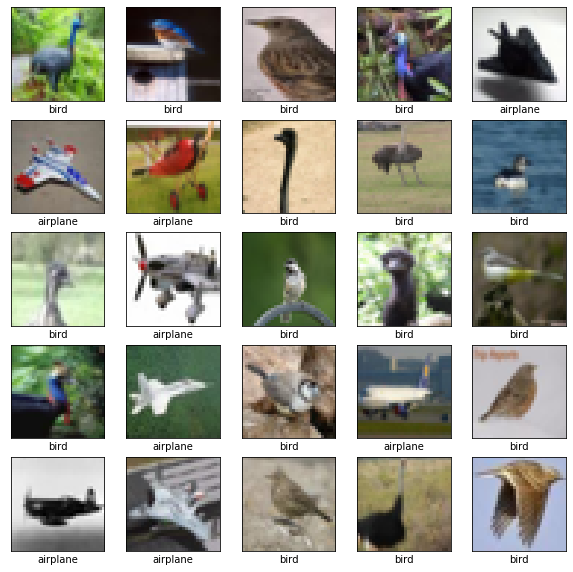

In [4]:
class_names = ['airplane', 'bird']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Define model



We'll define the model in the exact same fashion as before, only this time replacing the first convolutional layer in the model with a `tfp.layers.Convolution2DFlipout` layer object. The layer by default applies a normal prior distribution over its weights, so we don't need to define a prior ourselves.

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [9]:
checkpoint_path = 'saved_models/regular_binary_cnn.ckpt'

model.compile(optimizer=tf.optimizers.Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              experimental_run_tf_function=False  # Required argument for this probabilistic layer (and all Flipouts)
             )

## Train the model

Let's again load this model's trained weights from disk -- it takes about 10 minutes to train on a CPU.

In [ ]:
# # Run this to train the model from scratch

# # 

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# history = model.fit(train_images, train_labels, epochs=20, 
#                     validation_data=(test_images, test_labels), callbacks=[cp_callback])

# history_dict = history.history

# with open(os.path.join(os.getcwd(), 'saved_models', 'binary_cnn_history.pkl'), 'wb') as file:
#     pickle.dump(history_dict, file)

In [10]:
# Run this to instead load pre-trained weights
model.load_weights(checkpoint_path)

with open(os.path.join(os.getcwd(), 'saved_models', 'binary_cnn_history.pkl'), 'rb') as file:
    history_dict = pickle.load(file)

2000/2000 - 1s - loss: 0.4368 - accuracy: 0.9035


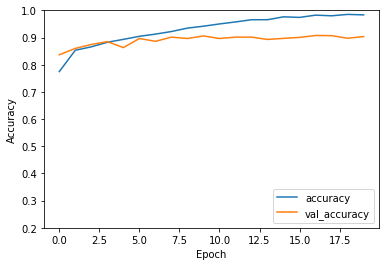

In [11]:
plt.plot(history_dict['accuracy'], label='accuracy')
plt.plot(history_dict['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

## Reasoning with uncertainty

Let's find what this model sees as the area of greatest uncertainty in the input images. This don't be uncertainty due to the data itself, but rather the test images most affected by the probabilistic variance in our first convolutional layer's weights.

Start by predicting over the entire test set 10 times.

In [12]:
yhats = model.predict(test_images)

In [13]:
df = pd.DataFrame(yhats)

In [14]:
most_uncertain = np.argmin(np.abs(df[0] - df[1]))

/Users/anglin/.pyenv/versions/3.7.2/envs/tensorflow2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


In [15]:
df.iloc[most_uncertain]

0    0.500041
1    0.499959
Name: 1910, dtype: float32

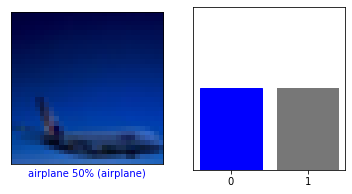

In [16]:
i = most_uncertain


plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, df.iloc[i].mean(), test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, df.iloc[i].mean(),  test_labels)
plt.show()

## Test sensitivity to adversarial data

Let's again pull in the full CIFAR-10 data set in order to give our model an image from outside the distribution it was trained on, in order to see if this model responds more appropriately than the one measuring aleatoric uncertainty.

In [17]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

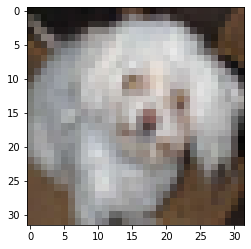

In [18]:
plt.imshow(test_images[1000], cmap=plt.cm.binary)

We'll predict over this image 1,000 times in order to get a distribution of predictions to work with.

In [19]:
dog_preds = model(test_images[1000:1001])

In [20]:
pd.DataFrame(dog_preds.numpy())

,0,1
0,0.000004,0.999996
